<a href="https://colab.research.google.com/github/DMTX2410/TL-P1/blob/main/Modelo_para_predecir_la_lluvia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np 
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [3]:
# Load file
filepath = "/content/drive/MyDrive/Datos/seattleWeather_1948-2017.csv"
df = pd.read_csv(filepath)

In [4]:
df['rain']=[1 if i==True else 0 for i in df['RAIN']]

In [5]:
class DFtoDataset(Dataset):
  def __init__(self,data):
    df=data
    x=df.iloc[:,0:3].values
    y=df.iloc[:,-1].values
    self.x_train=torch.tensor(x,dtype=torch.float32)
    self.y_train=torch.tensor(y,dtype=torch.float32)
    self.y_train = self.y_train.reshape((len(self.y_train), 1))

  def __len__(self):
    return len(self.y_train)
   
  def __getitem__(self,idx):
    return self.x_train[idx],self.y_train[idx]

In [6]:
dataset = DFtoDataset(df)
print(dataset.__len__())
print(dataset.__getitem__(2))
print(dataset.x_train.shape)
print(dataset.y_train.shape)

TypeError: ignored

In [ ]:
df2=df[['PRCP', 'TMAX', 'TMIN']].values
x = StandardScaler().fit_transform(df2)
y=df[['RAIN']].values
x,y

(array([[ 1.52191473, -0.66894103, -0.28273047],
        [ 2.02395052, -1.13869169, -0.95744409],
        [ 1.31273315, -1.13869169, -1.06989637],
        ...,
        [-0.44439214, -1.06039991, -1.40725318],
        [-0.44439214, -0.90381636, -1.18234864],
        [-0.44439214, -0.74723281, -0.95744409]]), array([[1],
        [1],
        [1],
        ...,
        [0],
        [0],
        [0]], dtype=uint8))

In [ ]:
x.shape, y.shape

((25551, 3), (25551, 1))

In [ ]:
X_Train, X_Test, Y_Train, Y_Test = train_test_split(x, y, test_size = 0.20, random_state = 42)
X_Train, X_Valid, Y_Train, Y_Valid = train_test_split(X_Train, Y_Train, test_size = 0.30, random_state = 42)

In [ ]:
# Converting data from Numpy to Torch Tensors
train = TensorDataset(torch.from_numpy(X_Train).float(), torch.from_numpy(Y_Train).float())
valid = TensorDataset(torch.from_numpy(X_Valid).float(), torch.from_numpy(Y_Valid).float())
test = TensorDataset(torch.from_numpy(X_Test).float(), torch.from_numpy(Y_Test).float())
# Creating data loaders
trainloader = DataLoader(train, batch_size=128, shuffle=True)
validloader = DataLoader(valid, batch_size=128, shuffle=True)
testloader = DataLoader(test, batch_size=128, shuffle=True)

In [ ]:
class ANN2(nn.Module):
    def __init__(self, input_size, hidden_size, hidden_size2, num_classes):
        super(ANN2, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) 
        self.fc2 = nn.Linear(hidden_size, hidden_size2) 
        self.fc3 = nn.Linear(hidden_size2, num_classes)  
    
    def forward(self, x):
        x = nn.Flatten(1, -1)(x)
        x = self.fc1(x)
        out = self.fc1(x)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out

In [ ]:
# Instatiating the model
model3 = ANN2(128, 64, 32, 1)
model3

ANN2(
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

In [ ]:
# Definir optimizador
params = model3.parameters()
optimiser = optim.SGD(params, lr=1e-2)

In [ ]:
# Definir función de costo
loss_function = nn.CrossEntropyLoss()

In [ ]:
# Training loop for each epoch
loss_plot, acc_plot = [], []
val_loss_plot, val_acc_plot = [], []
for epoch in range(12):
    total_loss, correct, total = 0, 0, 0
    model3.train()
    for x, y in trainloader: 
        # Zero the parameter gradients
        optimiser.zero_grad()
        # forward + loss + backward + optimise (update weights)
        output = model3(x)
        outputs = output.squeeze(1)
        loss = loss_function(outputs, y)
        loss.backward()
        optimiser.step()
        # Keeping track of the loss
        total_loss += loss.item() 
        output = F.softmax(output, dim=0)
        count = [1 for i, j in zip(output, y) if i == j]
        correct += sum(count)
        total += len(y)
    val_total_loss, val_correct, val_total = 0, 0, 0
    model3.eval()
    for x, y in validloader: 
        output = model3(x)
        outputs = output.squeeze(1)
        val_loss = loss_function(outputs, y)
        # Keeping track of the loss
        val_total_loss += val_loss.item()
        output = F.softmax(output, dim=0)
        val_count = [1 for i, j in zip(output, y) if i == j]
        val_correct += sum(val_count)
        val_total += len(y)

    acc = ((100.0 * correct) / total)
    val_acc = ((100.0 * val_correct) / val_total)
    epoch_loss = total_loss / len(trainloader)
    val_epoch_loss = val_total_loss / len(testloader)
    print("Epoch: %d, Loss: %4.2f, Accuracy: %2.2f" % (epoch, 
                                                         epoch_loss, 
                                                           acc) + '%')
    print("Validation, Loss: %4.2f, Accuracy: %2.2f" % (val_epoch_loss, 
                                                           val_acc) + '%')
    loss_plot.append(total_loss)
    acc_plot.append(acc)
    val_loss_plot.append(val_total_loss)
    val_acc_plot.append(val_acc)

RuntimeError: ignored

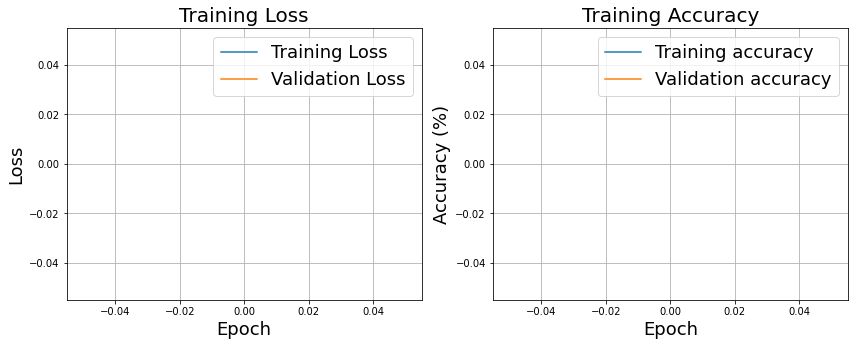

In [ ]:
def train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    #plt.tight_layout()
    ax[0].plot(loss_plot, label="Training Loss")
    ax[0].plot(val_loss_plot, label="Validation Loss")
    ax[0].legend(fontsize=18)
    ax[0].grid(True)
    ax[0].set_title("Training Loss", fontsize=20);
    ax[0].set_xlabel("Epoch", fontsize=18);
    ax[0].set_ylabel("Loss", fontsize=18);
    ax[1].plot(acc_plot, label="Training accuracy")
    ax[1].plot(val_acc_plot, label="Validation accuracy")
    ax[1].legend(fontsize=18)
    ax[1].grid(True)
    ax[1].set_title("Training Accuracy", fontsize=20);
    ax[1].set_xlabel("Epoch", fontsize=18);
    ax[1].set_ylabel("Accuracy (%)", fontsize=18);
    #plt.savefig("Training.png", format='png', dpi=1200)
    
train_val_plot(loss_plot, val_loss_plot, acc_plot, val_acc_plot)

In [ ]:
def test_model(model, testloader):
    model.eval()
    # Computing the model accuracy on the test set
    correct, total = 0, 0
    for x, y in testloader:
        outputs = model(x)
        winners = outputs.argmax(dim=1)
        count = [1 for i, j in zip(winners, y.long()) if i == j]
        correct += sum(count)
        total += len(y)
    print('Test Accuracy: %2.2f %%' % ((100.0 * correct) / total))
    
test_model(model, testloader)

RuntimeError: ignored